In [1]:
# import packages
import os
import urllib.request

#create a fold for the dataset
os.makedirs('./data', exist_ok = True)
# load dataset to the directory, as you can see, you need to load train sets and test sets seperately 
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename='./data/train-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename='./data/train-labels.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename='./data/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename='./data/test-labels.gz')

print('Code executed')

Code executed


In [2]:
# functions needed by downstream code...

# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

import gzip
import numpy as np
import struct

# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res


# one-hot encode a 1-D array
def one_hot_encode(array, num_of_classes):
    return np.eye(num_of_classes)[array.reshape(-1)]

# load the data...

# To help the model to converge faster , you shrink the intensity values (X) from 0-255 to 0-1
X_train = load_data('./data/train-images.gz', False) / 255.0
y_train = load_data('./data/train-labels.gz', True).reshape(-1)

X_test = load_data('./data/test-images.gz', False) / 255.0
y_test = load_data('./data/test-labels.gz', True).reshape(-1)

print('Code executed')

Code executed


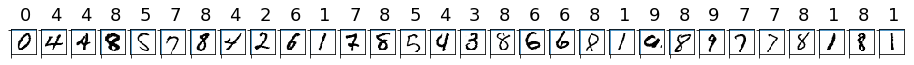

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

In [4]:
from sklearn.linear_model import LogisticRegression

#load model
clf = LogisticRegression()
#fit model
clf.fit(X_train, y_train)

#evaluate model using test set
y_hat = clf.predict(X_test)
#print the accuracy
print(np.average(y_hat == y_test))

print('Code executed')

0.9201
Code executed


In [5]:
# Add this to top of code...
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import azureml
from azureml.core import Workspace, Run

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.17


In [1]:
ws = Workspace.get(name='###',
                      subscription_id='####', 
                      resource_group='###' 
                     )

In [2]:
ws.get_details()

In [9]:
from azureml.core import Workspace
ws = Workspace.create(name='###',
                 subscription_id='###', 
                 resource_group='###', 
                 create_resource_group=True,
                 location='eastus2' 
                 )

Deploying ContainerRegistry with name ml2303lracrckyedxsz.
Deployed ContainerRegistry with name ml2303lracrckyedxsz.
Deploying KeyVault with name ml2303lrkeyvaultgucutinn.
Deploying StorageAccount with name ml2303lrstoragehfnnmfst.
Deployed KeyVault with name ml2303lrkeyvaultgucutinn.
Deploying AppInsights with name ml2303lrinsightskkkmlxvj.
Deployed AppInsights with name ml2303lrinsightskkkmlxvj.
Deployed StorageAccount with name ml2303lrstoragehfnnmfst.
Deploying Workspace with name ML2303_LR.
Deployed Workspace with name ML2303_LR.


In [3]:
ws.get_details()

In [13]:
from azureml.core import Experiment
#Create an experiment
experiment = Experiment(workspace = ws, name = "my-first-experiment_lr")
#Create a run
run = experiment.start_logging()
run.log("trial",1)
run.complete()
print('Code executed')

Code executed


In [4]:
print(run.get_portal_url())

In [15]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# Step 1: name the cluster, set minimal and maximal number of nodes 
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpucluster")
min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 3)

# Step 2: choose environment variables 
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")


provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = min_nodes, 
                                                                max_nodes = max_nodes)

# create the cluster
compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
print('Code executed')

Code executed


In [16]:
#upload data using get_default_datastore()
ds = ws.get_default_datastore()

ds.upload(src_dir='./data', target_path='mnist', overwrite=True, show_progress=True)
print('Code executed')

Uploading ./data/test-images.gz
Uploading ./data/test-labels.gz
Uploading ./data/train-images.gz
Uploading ./data/train-labels.gz
Uploaded ./data/test-labels.gz, 1 files out of an estimated total of 4
Uploaded ./data/train-labels.gz, 2 files out of an estimated total of 4
Uploaded ./data/test-images.gz, 3 files out of an estimated total of 4
Uploaded ./data/train-images.gz, 4 files out of an estimated total of 4
Code executed


In [17]:
#import os if you haven't done so
import os

#create folder
folder_training_script= './trial_model_mnist'
os.makedirs(folder_training_script, exist_ok=True)

In [18]:
%%writefile $folder_training_script/train.py

# functions needed by downstream code...

# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

import gzip
import numpy as np
import struct

# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res


# one-hot encode a 1-D array
def one_hot_encode(array, num_of_classes):
    return np.eye(num_of_classes)[array.reshape(-1)]
#

# end of functions needed by downstream code...

import argparse
import os
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

from azureml.core import Run
# from utils import load_data

# let user feed in 2 parameters, the location of the data files (from datastore), and the regularization rate of the logistic regression model
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--regularization', type=float, dest='reg', default=0.01, help='regularization rate')
args = parser.parse_args()

data_folder = os.path.join(args.data_folder, 'mnist')
print('Data folder:', data_folder)

# load train and test set into numpy arrays
# note we scale the pixel intensity values to 0-1 (by dividing it with 255.0) so the model can converge faster.
X_train = load_data(os.path.join(data_folder, 'train-images.gz'), False) / 255.0
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_train = load_data(os.path.join(data_folder, 'train-labels.gz'), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep = '\n')

# get hold of the current run
run = Run.get_context()

print('Train a logistic regression model with regularizaion rate of', args.reg)
clf = LogisticRegression(C=1.0/args.reg, random_state=42)
clf.fit(X_train, y_train)

print('Predict the test set')
y_hat = clf.predict(X_test)

# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

run.log('regularization rate', np.float(args.reg))
run.log('accuracy', np.float(acc))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')

print('Code executed')

Writing ./trial_model_mnist/train.py


In [19]:
from azureml.train.estimator import Estimator

script_params = {
    '--data-folder': ds.as_mount(),
    '--regularization': 0.8
}

#import scikit-learn package 
est = Estimator(source_directory=folder_training_script,
                script_params=script_params,
                compute_target=compute_target,
                entry_script='train.py',
                conda_packages=['scikit-learn'])

In [20]:
#run
run = experiment.submit(config=est)
run

print('Code executed')

Code executed


In [21]:
# monitor the run
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [23]:
#get result
print(run.get_metrics())

{'regularization rate': 0.8, 'accuracy': 0.9204}


In [24]:
ws.delete(delete_dependent_resources=True)